In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def loadSimpData():
    datMat = np.mat([[1.,2.1],[2.,1.1],[1.3,1.],[1.,1.],[2.,1.]])
    classLabels = [1.,1.,-1.,-1.,1.]
    
    return datMat , classLabels

In [3]:
datMat , classLabels = loadSimpData()

In [4]:
datMat

matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])

In [5]:
def stumpClassify(dataMatrix , dimen , threshVal , threshIneq):#决策树桩分类器
    retArray = np.ones((dataMatrix.shape[0] , 1))
    
    if threshIneq == 'lt':
        retArray[dataMatrix[: , dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[: , dimen] > threshVal] = -1.0
    
    return retArray


def buildStump(dataArr , classLabels , D):#开始构建树桩 要选择使平均错误率最低的树桩函数
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m,n = dataMatrix.shape
    
    numSteps = 10.0
    bestStump = {}
    bestClasEst = np.mat(np.zeros((m , 1)))
    minError = np.inf
    
    for i in range(n):#每个特征都过一遍
        rangeMin = dataMatrix[: , i].min()#特征最大值
        rangeMax = dataMatrix[: , i].max()#特征最小值
        
        stepSize = (rangeMax- rangeMin)/numSteps #计算步长
        
        for j in range(-1 , int(numSteps)+1):#按间隔分割开来后 后面计算阈值
            for inequal in ['lt' , 'gt']:
                threshVal = (rangeMin + float(j)*stepSize)
                predictedVals = stumpClassify(dataMatrix , i , threshVal , inequal)
                
                errArr = np.mat(np.ones((m , 1)))
                errArr[predictedVals == labelMat] = 0 #统计分类错误数
                
                weightedError = D.T * errArr#计算加权错误概率
                
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    
    return bestStump , minError ,bestClasEst


            

In [6]:
D=np.mat(np.ones((5,1))/5)
buildStump(datMat , classLabels , D)

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[ 0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [22]:
def adaBoostTrainDS(dataArr , classLabels , numIt = 40):
    weakClassArr = []
    
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m , 1))/m)
    
    aggClassEst = np.mat(np.zeros((m , 1)))
    
    for i in range(numIt):
        bestStump , error , classEst = buildStump(dataArr , classLabels , D)
        
        alpha = float(0.5*np.log((1.0-error)/max(error , 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        
        expon = np.multiply(-1*alpha*np.mat(classLabels).T , classEst)
        D = np.multiply(D , np.exp(expon))
        D = D/D.sum()
        
        aggClassEst += alpha*classEst
        
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T , np.ones((m , 1)))
        
        errorRate = aggErrors.sum()/m
        
        print('total error :' , errorRate)
        
        if errorRate == 0.0: 
            break
    
    #return weakClassArr , aggClassEst#绘制ROC时 补充
    return weakClassArr #正常使用

In [8]:
classifierArray = adaBoostTrainDS(datMat , classLabels , 9)

total error : 0.2
total error : 0.2
total error : 0.0


In [9]:
classifierArray

[{'alpha': 0.6931471805599453, 'dim': 0, 'ineq': 'lt', 'thresh': 1.3},
 {'alpha': 0.9729550745276565, 'dim': 1, 'ineq': 'lt', 'thresh': 1.0},
 {'alpha': 0.8958797346140273,
  'dim': 0,
  'ineq': 'lt',
  'thresh': 0.90000000000000002}]

In [10]:
#下面是测试算法效果
def adaClassify(datToClass , classifierArr):
    dataMatrix = np.mat(datToClass)
    m = dataMatrix.shape[0]
    
    aggClassEst = np.mat(np.zeros((m,1)))
    
    for i in range(len(classifierArr)):
        #下面是基于决策树桩得到一个基本的类别估计值
        classEst = stumpClassify(dataMatrix , classifierArr[i]['dim'] , classifierArr[i]['thresh'] , classifierArr[i]['ineq'])
        #进行加权计算
        aggClassEst += classifierArr[i]['alpha']*classEst
        
        print(aggClassEst)
    
    return np.sign(aggClassEst)


In [11]:
adaClassify([0,0] , classifierArray)

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [12]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat=[]
    labelMat=[]
    
    fr = open(fileName)
    
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    
    return dataMat , labelMat


In [16]:
datArr , labelArr = loadDataSet('../MLiA_SourceCode/Ch07/horseColicTraining2.txt')
classifierArray = adaBoostTrainDS(datArr , labelArr)

total error : 0.284280936455
total error : 0.284280936455
total error : 0.247491638796
total error : 0.247491638796
total error : 0.254180602007
total error : 0.240802675585
total error : 0.240802675585
total error : 0.220735785953
total error : 0.247491638796
total error : 0.230769230769
total error : 0.240802675585
total error : 0.214046822742
total error : 0.227424749164
total error : 0.217391304348
total error : 0.220735785953
total error : 0.217391304348
total error : 0.224080267559
total error : 0.224080267559
total error : 0.230769230769
total error : 0.224080267559
total error : 0.214046822742
total error : 0.207357859532
total error : 0.224080267559
total error : 0.224080267559
total error : 0.214046822742
total error : 0.220735785953
total error : 0.204013377926
total error : 0.207357859532
total error : 0.210702341137
total error : 0.217391304348
total error : 0.210702341137
total error : 0.217391304348
total error : 0.207357859532
total error : 0.210702341137
total error : 

In [17]:
testArr , testLabelArr = loadDataSet('../MLiA_SourceCode/Ch07/horseColicTest2.txt')
prediction10 = adaClassify(testArr , classifierArray)

[[ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

In [18]:
errArr = np.mat(np.ones((67 , 1)))
errArr[prediction10 != np.mat(testLabelArr).T].sum()

13.0

In [19]:
13/67


0.19402985074626866

In [24]:
def plotROC(predStrengths , classLabels):
    cur = (1. , 1.)
    ySum = 0.0
    
    numPosClas = np.sum(np.array(classLabels) == 1.0)
    yStep = 1/float(numPosClas)
    xStep = 1/float(len(classLabels) - numPosClas)
    
    sortedIndices = predStrengths.argsort()
    
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    
    for index in sortedIndices.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        
        ax.plot([cur[0] , cur[0]-delX] , [cur[1] , cur[1] - delY] , c='b')
        cur = (cur[0]-delX , cur[1] - delY)
    
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('roc')
    ax.axis([0,1,0,1])
    plt.show()
    print('the area AUC:',ySum*xStep)

total error : 0.284280936455
total error : 0.284280936455
total error : 0.247491638796
total error : 0.247491638796
total error : 0.254180602007
total error : 0.240802675585
total error : 0.240802675585
total error : 0.220735785953
total error : 0.247491638796
total error : 0.230769230769


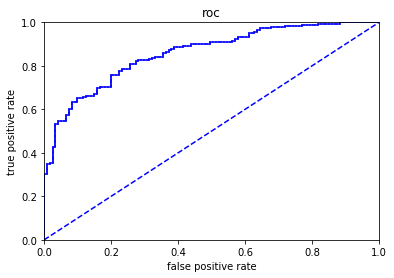

the area AUC: 0.8582969635063604


In [25]:
classifierArray , aggClassEst = adaBoostTrainDS(datArr , labelArr , 10)
plotROC(aggClassEst.T , labelArr)
#绘制曲线 将adaBoostTrainDS函数最后一行代码 修改为return weakClassArr , aggClassEst
